### Defensive Positioning Metric - Squeezing? Positioning?

In [5]:
import os
import requests
import itertools
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from kloppy import skillcorner
from concurrent.futures import ThreadPoolExecutor, as_completed
import pickle as pkl
import json
from io import StringIO

In [6]:
# CONFIGURATION
MATCH_IDS = [
    "1886347", "1899585", "1925299","1953632","1996435","2006229","2011166",
    "2013725","2015213","2017461"]

BASE_URL = "https://raw.githubusercontent.com/SkillCorner/opendata/master/data/matches"
DATA_DIR = "opendata/data/matches"  # local path for JSON/JSONL files
PITCH_LENGTH = 105.0
PITCH_WIDTH = 68.0
FPS = 10
MAX_SPEED = 11
MAX_ACCEL = 9
WINDOW = 7
POLYORDER = 1

In [7]:
# LOADING FUNCTION 1

def load_tracking_data(match_id):
    """Load tracking data (local JSON + JSONL via kloppy)."""
    meta_path = f"{DATA_DIR}/{match_id}/{match_id}_match.json"
    tracking_path = f"{DATA_DIR}/{match_id}/{match_id}_tracking_extrapolated.jsonl"

    dataset = skillcorner.load(
        meta_data=meta_path,
        raw_data=tracking_path,
        sample_rate=None,
        include_empty_frames=True
    )

    rows = []
    for i, frame in enumerate(dataset.records):
        timestamp = i / FPS
        ball = frame.ball_coordinates
        ball_x = getattr(ball, "x", None)
        ball_y = getattr(ball, "y", None)
        ball_z = getattr(ball, "z", None)
        ball_team = frame.ball_owning_team.name if frame.ball_owning_team else None
        attacking_dir = frame.attacking_direction

        for player_obj, coord in frame.players_coordinates.items():
            player_data = frame.players_data.get(player_obj, None)
            rows.append({
                "match_id": match_id,
                "timestamp": timestamp,
                "period": frame.period.id,
                "player_id": player_obj.player_id,
                "player_name": player_obj.name,
                "team_id": player_obj.team.team_id,
                "team_name": player_obj.team.name,
                "x": coord.x, "y": coord.y,
                "ball_x": ball_x, "ball_y": ball_y,
                "attacking_direction": attacking_dir,
                "ball_owning_team": ball_team,
                "speed": getattr(player_data, "speed", None) if player_data else None,
                "acceleration": getattr(player_data, "acceleration", None) if player_data else None
            })
    return pd.DataFrame(rows)



In [8]:
## loading Function 2

def load_match_metadata(match_id):
    base_path = f"{DATA_DIR}/{match_id}/{match_id}"

    # Pass file paths directly to skillcorner (like load_tracking_data)
    # But skillcorner.load only supports metadata JSON, so here just load JSON normally from file
    with open(f"{base_path}_match.json", 'r', encoding='utf-8') as f:
        match_json = json.load(f)

    dynamic_events_df = pd.read_csv(f"{base_path}_dynamic_events.csv")
    phases_of_play_df = pd.read_csv(f"{base_path}_phases_of_play.csv")

    return match_json, dynamic_events_df, phases_of_play_df


In [15]:
#Extract positional column and map to tracking data df
def load_player_positions(match_id):
    meta_path = f"{DATA_DIR}/{match_id}/{match_id}_match.json"
    
    with open(meta_path, 'r', encoding='utf-8') as f:
        metadata = json.load(f)
    
    df_meta = pd.DataFrame([metadata])
    df_exploded = df_meta.explode("players", ignore_index=True)
    player_cols = pd.json_normalize(df_exploded["players"]).add_prefix("player_")
    df_final = df_exploded.drop(columns=["players"]).join(player_cols)
    
    player_map = df_final[[
        "player_id",
        "player_player_role.acronym"
    ]].drop_duplicates()
    
    player_map = player_map.rename(columns={"player_player_role.acronym": "position_group"})
    player_map["match_id"] = match_id
    
    return player_map

In [16]:
## processing Function 1

def normalize_coordinates(df):
    df = df.copy()
    df['x_m'] = (df['x'] - df['x'].min()) / (df['x'].max() - df['x'].min()) * PITCH_LENGTH - PITCH_LENGTH/2
    df['y_m'] = (df['y'] - df['y'].min()) / (df['y'].max() - df['y'].min()) * PITCH_WIDTH - PITCH_WIDTH/2
    df['ball_x_m'] = (df['ball_x'] - df['ball_x'].min()) / (df['ball_x'].max() - df['ball_x'].min()) * PITCH_LENGTH - PITCH_LENGTH/2
    df['ball_y_m'] = (df['ball_y'] - df['ball_y'].min()) / (df['ball_y'].max() - df['ball_y'].min()) * PITCH_WIDTH - PITCH_WIDTH/2
    return df

In [17]:
## processing Function 2

def smooth_and_clean(df, fps=10, maxspeed=12, maxaccel=9, window=7, polyorder=1):
    """
    Smooth speed/acceleration and clean outliers for a tracking half.
    """
    df = df.sort_values(['player_id', 'timestamp']).copy()

    # ---- Compute velocity components ----
    df['dt'] = df.groupby('player_id')['timestamp'].diff()
    df['dx'] = df.groupby('player_id')['x_m'].diff()
    df['dy'] = df.groupby('player_id')['y_m'].diff()

    df = df[df['dt'] > 0]
    df['raw_speed'] = np.sqrt((df['dx']/df['dt'])**2 + (df['dy']/df['dt'])**2)

    # ---- Smooth velocity ----
    def smooth_player(g):
        g = g.copy()
        g['vx'] = g['dx'] / g['dt']
        g['vy'] = g['dy'] / g['dt']
        if len(g) >= window:
            g['vx'] = savgol_filter(g['vx'].fillna(method='ffill').fillna(method='bfill'),
                                    window_length=window, polyorder=polyorder)
            g['vy'] = savgol_filter(g['vy'].fillna(method='ffill').fillna(method='bfill'),
                                    window_length=window, polyorder=polyorder)
        g['speed'] = np.sqrt(g['vx']**2 + g['vy']**2)
        return g

    df = df.groupby('player_id', group_keys=False).apply(smooth_player)

    # ---- Compute acceleration ----
    df['speed_smooth'] = (
        df.groupby('player_id')['speed']
        .transform(lambda x: x.rolling(fps, min_periods=1).mean())
    )
    df['acceleration'] = df.groupby('player_id')['speed_smooth'].diff(fps) / 1.0

    # ---- Outlier removal ----
    df['is_outlier'] = (df['speed'] > maxspeed) | (df['acceleration'].abs() > maxaccel)
    df.loc[df['is_outlier'], 'speed'] = np.nan
    df['speed'] = df['speed'].interpolate(limit_direction='both')

    return df

In [18]:
## convex Hull area Function 
def compute_convex_hull_area(points):
    if len(points) < 3:
        return np.nan
    try:
        hull = ConvexHull(points)
        return hull.area
    except:
        return np.nan

In [19]:
## Ball owning team function 

def calculate_possession(df, dist_thresh=2.0, min_hold_frames=3):
    current_team = None
    hold_counter = 0
    possession_id = 0
    id_counter = itertools.count(1)
    possession_map = {}

    for ts, frame_df in df.groupby('timestamp'):
        bx, by = frame_df[['ball_x_m', 'ball_y_m']].iloc[0]
        frame_df['dist_to_ball'] = np.sqrt((frame_df['x_m'] - bx)**2 + (frame_df['y_m'] - by)**2)
        closest_player = frame_df.nsmallest(1, 'dist_to_ball').iloc[0]
        closest_team = closest_player['team_id']
        closest_dist = closest_player['dist_to_ball']

        if current_team is None:
            # Start possession if ball is close enough
            if closest_dist <= dist_thresh:
                current_team = closest_team
                possession_id = next(id_counter)
        else:
            # If different team tries to take possession
            if closest_team != current_team and closest_dist <= dist_thresh:
                hold_counter += 1
                # Only switch after min_hold_frames consecutive frames
                if hold_counter >= min_hold_frames:
                    current_team = closest_team
                    possession_id = next(id_counter)
                    hold_counter = 0
            else:
                hold_counter = 0

        possession_map[ts] = (possession_id, current_team)

    # Map possession info back to dataframe by timestamp
    df['possession_id'] = df['timestamp'].map(lambda t: possession_map[t][0])
    df['ball_owning_team'] = df['timestamp'].map(lambda t: possession_map[t][1])
    return df

In [20]:
## Convex Hull functin 
def calculate_convex_hulls(df):
    df = df.copy()
    df['convex_hull_surface_area'] = np.nan

    for ts, frame in tqdm(df.groupby('timestamp'), desc="Calculating convex hulls"):
        ball_team = frame['ball_owning_team'].iloc[0]

        # Defending players (non-ball-owning team)
        defending_frame = frame[frame['team_id'] != ball_team]

        if defending_frame.empty:
            continue

        # Loop through each defending player
        for idx, row in defending_frame.iterrows():

            #  EXCLUDE goalkeeper
            if row.get('position_group') == "GK":
                continue

            # Get teammates (excluding GK + excluding the player himself)
            teammates = frame.loc[
                (frame['team_id'] == row['team_id']) &
                (frame['player_id'] != row['player_id']) &
                (frame['position_group'] != "GK"),
                ['x_m', 'y_m']
            ]

            # Need at least 3 teammates
            if len(teammates) < 3:
                continue

            # Compute distances to find nearest 3 teammates
            teammates['dist'] = np.sqrt(
                (teammates['x_m'] - row['x_m'])**2 +
                (teammates['y_m'] - row['y_m'])**2
            )
            nearest = teammates.nsmallest(3, 'dist')

            # Build convex hull points
            #  Only: player + 3 nearest teammates (NO ball)
            points = np.vstack([
                [row['x_m'], row['y_m']],
                nearest[['x_m', 'y_m']].to_numpy()
            ])

            # Compute hull area
            area = compute_convex_hull_area(points)
            df.at[idx, 'convex_hull_surface_area'] = area

    return df

In [21]:
# --- Helper functions ---
def parse_time_to_seconds(t):
    """Convert 'MM:SS:s' or 'M:S:s' or 'H:M:S' to seconds as float."""
    if pd.isna(t):
        return np.nan
    try:
        parts = str(t).split(':')
        if len(parts) == 3:
            h_or_m, m_or_s, s = parts
            if int(h_or_m) < 10:  # assume MM:SS:s
                minutes, seconds, tenths = map(float, parts)
                return minutes * 60 + seconds + tenths / 10
            else:  # assume H:M:S
                hours, minutes, seconds = map(float, parts)
                return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:
            minutes, seconds = map(float, parts)
            return minutes * 60 + seconds
        else:
            return float(parts[0])
    except Exception:
        return np.nan

In [22]:
# --- Phase and event merging ---
def merge_phases_and_events(tracking_df, phases_df, events_df):
    """
    Merges phase-of-play and dynamic event information into the tracking data
    across both halves for a given match.
    """
    merged = tracking_df.copy()

    # Convert timestamps (seconds already from tracking)
    merged['event_subtype'] = np.nan
    merged['team_in_possession_phase_type'] = np.nan

    # Convert phase times
    phases_df = phases_df.copy()
    phases_df['start_time_seconds'] = (
        phases_df['minute_start'] * 60 + phases_df['second_start']
    )
    phases_df['end_time_seconds'] = phases_df['time_end'].apply(parse_time_to_seconds)

    # Fallback: use duration if missing
    phases_df['end_time_seconds'] = phases_df['end_time_seconds'].fillna(
        phases_df['start_time_seconds'] + phases_df['duration']
    )

    # --- Process both halves separately ---
    for period in [1, 2]:
        half_df = merged[merged['period'] == period]
        phases_half = phases_df[phases_df['period'] == period].sort_values('start_time_seconds')

        # Assign phases
        for _, row in phases_half.iterrows():
            start, end, phase_value = row['start_time_seconds'], row['end_time_seconds'], row['team_in_possession_phase_type']
            mask = (half_df['timestamp'] >= start) & (half_df['timestamp'] <= end)
            merged.loc[mask & (merged['period'] == period), 'team_in_possession_phase_type'] = phase_value

    # --- Dynamic events ---
    events_df = events_df.copy()
    events_df['time_start'] = events_df['time_start'].apply(parse_time_to_seconds)
    events_df['time_end'] = events_df['time_end'].apply(parse_time_to_seconds)
    events_df = events_df.sort_values('time_start')

    for _, event in events_df.iterrows():
        player = event['player_id']
        start, end, subtype, period = event['time_start'], event['time_end'], event['event_subtype'], event['period']
        mask = (
            (merged['player_id'] == player)
            & (merged['period'] == period)
            & (merged['timestamp'] >= start)
            & (merged['timestamp'] <= end)
        )
        merged.loc[mask, 'event_subtype'] = subtype

    return merged

In [28]:
## Per match processing 

def process_match(match_id):
    try:
        print(f"🟩 Starting match {match_id}")
        
        match_json, dynamic_df, phases_df = load_match_metadata(match_id)
        tracking_df = load_tracking_data(match_id)
        tracking_df = normalize_coordinates(tracking_df)
        tracking_df = smooth_and_clean(tracking_df)
        tracking_df = calculate_possession(tracking_df)
        player_positions = load_player_positions(match_id)
        
        # Convert player_id columns to pandas nullable Int64 type
        tracking_df['player_id'] = tracking_df['player_id'].astype('Int64')
        player_positions['player_id'] = player_positions['player_id'].astype('Int64')
        
        # Now merge safely
        tracking_df = tracking_df.merge(
            player_positions[['player_id', 'position_group']],
            how='left',
            on='player_id'
        )
        
        tracking_df = calculate_convex_hulls(tracking_df)
        tracking_df = merge_phases_and_events(tracking_df, phases_df, dynamic_df)
        
        print(f"✅ Finished match {match_id}")
        return {
            "match_id": match_id,
            "tracking": tracking_df,
            "dynamic": dynamic_df.assign(match_id=match_id),
            "phases": phases_df.assign(match_id=match_id)
        }
    except Exception as e:
        print(f"❌ Error processing match {match_id}: {e}")
        return None

In [29]:
# Call th functions and run

results = []
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = {executor.submit(process_match, match_id): match_id for match_id in MATCH_IDS}
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing matches"):
        res = future.result()
        if res:
            results.append(res)


# Combine outputs
df_all_tracking = pd.concat([r["tracking"] for r in results], ignore_index=True)
df_all_dynamic = pd.concat([r["dynamic"] for r in results], ignore_index=True)
df_all_phases = pd.concat([r["phases"] for r in results], ignore_index=True)

print("\n✅ All matches processed successfully!")
print(f"Total frames: {len(df_all_tracking):,}")
print(f"Dynamic events: {len(df_all_dynamic):,}")
print(f"Phases: {len(df_all_phases):,}")


🟩 Starting match 1886347
🟩 Starting match 1899585
🟩 Starting match 1925299
🟩 Starting match 1953632
🟩 Starting match 1996435
🟩 Starting match 2006229
🟩 Starting match 2011166
🟩 Starting match 2013725


Processing matches:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\3858413467.py:23: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  dynamic_events_df = pd.read_csv(f"{base_path}_dynamic_events.csv")
C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\1666579535.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  g['vx'] = savgol_filter(g['vx'].fillna(method='ffill').fillna(method='bfill'),
C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\1666579535.py:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  g['vy'] = savgol_filter(g['vy'].fillna(method='ffill').fillna(method='bfill'),
C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\1666579535.py:25: FutureWarning: Series.f

✅ Finished match 2013725



Calculating convex hulls:   5%|▌         | 1625/30825 [16:56<1:25:47,  5.67it/s]







Calculating convex hulls:   5%|▌         | 1626/30825 [16:56<1:22:47,  5.88it/s]







Calculating convex hulls:   5%|▌         | 1627/30825 [16:56<1:20:02,  6.08it/s]







Calculating convex hulls:   5%|▌         | 1628/30825 [16:56<1:19:57,  6.09it/s]







Calculating convex hulls:   5%|▌         | 1629/30825 [16:56<1:16:59,  6.32it/s]







Calculating convex hulls:   5%|▌         | 1630/30825 [16:56<1:15:20,  6.46it/s]







Calculating convex hulls:   5%|▌         | 1631/30825 [16:57<1:12:54,  6.67it/s]







Calculating convex hulls:   5%|▌         | 1632/30825 [16:57<1:12:48,  6.68it/s]







Calculating convex hulls:   5%|▌         | 1633/30825 [16:57<1:11:23,  6.82it/s]







Calculating convex hulls:   5%|▌         | 1634/30825 [16:57<1:10:44,  6.88it/s]







Calculating convex hulls:   5%|▌         | 1635/30825 [16:57<1:08:29,  7.10it/s]







Calculating convex hulls:   5%|

✅ Finished match 1925299


Calculating convex hulls:  22%|██▏       | 6792/30825 [30:10<34:35, 11.58it/s]

Calculating convex hulls:  22%|██▏       | 6794/30825 [30:10<32:41, 12.25it/s]

Calculating convex hulls:  22%|██▏       | 6796/30825 [30:10<31:30, 12.71it/s]

Calculating convex hulls:  22%|██▏       | 6798/30825 [30:10<30:30, 13.12it/s]

Calculating convex hulls:  22%|██▏       | 6800/30825 [30:10<29:41, 13.48it/s]

Calculating convex hulls:  22%|██▏       | 6802/30825 [30:11<29:14, 13.69it/s]

Calculating convex hulls:  22%|██▏       | 6804/30825 [30:11<28:47, 13.91it/s]

Calculating convex hulls:  22%|██▏       | 6806/30825 [30:11<28:52, 13.87it/s]

Calculating convex hulls:  22%|██▏       | 6808/30825 [30:11<28:06, 14.24it/s]

Calculating convex hulls:  22%|██▏       | 6810/30825 [30:11<27:48, 14.40it/s]

Calculating convex hulls:  22%|██▏       | 6812/30825 [30:11<27:02, 14.80it/s]

Calculating convex hulls:  22%|██▏       | 6814/30825 [30:11<27:06, 14.76it/s]

Calculating convex hulls:  22%|██▏      

✅ Finished match 2017461


Processing matches: 100%|██████████| 10/10 [4:13:02<00:00, 1518.27s/it]

✅ Finished match 2015213



✅ All matches processed successfully!
Total frames: 6,785,748
Dynamic events: 47,853
Phases: 4,581


In [36]:
### <------------------- THIS IS A SAVE AS A CHECKPOINT, NOT FOR STREAMLIT APP --------------------->

import pickle
df_all_tracking.to_pickle('skillcorner_x_pysport_v2.pkl')

### <-------------- THIS NEXT PART IS FOR VALIDATION OF THE DEFENSIVE METRIC ----------------->

In [41]:
all_matches = {}

for match_id in MATCH_IDS:
    print(f"Loading match {match_id}...")
    match_json, dynamic_events_df, phases_of_play_df = load_match_metadata(match_id)
    all_matches[match_id] = {
        "metadata": match_json,
        "dynamic_events": dynamic_events_df,
        "phases_of_play": phases_of_play_df
    }

print("All matches loaded!")

Loading match 1886347...
Loading match 1899585...


C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\3858413467.py:23: DtypeWarning: Columns (276) have mixed types. Specify dtype option on import or set low_memory=False.
  dynamic_events_df = pd.read_csv(f"{base_path}_dynamic_events.csv")


Loading match 1925299...
Loading match 1953632...
Loading match 1996435...
Loading match 2006229...
Loading match 2011166...
Loading match 2013725...
Loading match 2015213...
Loading match 2017461...
All matches loaded!


C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\3858413467.py:23: DtypeWarning: Columns (75,77,184,264) have mixed types. Specify dtype option on import or set low_memory=False.
  dynamic_events_df = pd.read_csv(f"{base_path}_dynamic_events.csv")


In [52]:
# Combine all dynamic events across matches
dynamic_events_df = pd.concat(
    [m["dynamic_events"].assign(match_id=match_id) for match_id, m in all_matches.items()],
    ignore_index=True
)



In [42]:
metadata_df = pd.concat(
    [pd.DataFrame([m["metadata"]]).assign(match_id=match_id) for match_id, m in all_matches.items()],
    ignore_index=True
)


In [43]:
df_exploded = metadata_df.explode("players").reset_index(drop=True)

player_cols = pd.json_normalize(df_exploded["players"])
player_cols = player_cols.add_prefix("player_")

df_final = df_exploded.drop(columns=["players"]).join(player_cols)

In [53]:
phases_of_play_df = pd.concat(
    [m["phases_of_play"].assign(match_id=match_id) for match_id, m in all_matches.items()],
    ignore_index=True
)


### <---------- CALCULATE HOW MANY LINE BREAKING PASSES EACH TEAM CONCEDES ------------>

In [55]:
# Identify line breaking passes that went through
new_cols = pd.DataFrame({
    'first_line_break_through': (
        (dynamic_events_df['first_line_break'] == True) &
        (dynamic_events_df['first_line_break_type'] == 'through')
    ),
    'second_last_line_break_through': (
        (dynamic_events_df['second_last_line_break'] == True) &
        (dynamic_events_df['second_last_line_break_type'] == 'through')
    ),
    'last_line_break_through': (
        (dynamic_events_df['last_line_break'] == True) &
        (dynamic_events_df['last_line_break_type'] == 'through')
    )
})

# Join 
dynamic_events_df = pd.concat([dynamic_events_df, new_cols], axis=1)

In [56]:

dynamic_events_df['total_line_breaking_passes'] = (
    dynamic_events_df[['first_line_break_through', 'second_last_line_break_through', 'last_line_break_through']]
    .sum(axis=1)
)

In [57]:
# Step 3a: Create a mapping of which teams played in each match
match_teams = dynamic_events_df.groupby('match_id')['team_id'].unique().to_dict()

# Step 3b: Create a new column for the team that conceded (the opponent)
def get_opponent(row):
    teams = match_teams[row['match_id']]
    return next(t for t in teams if t != row['team_id'])

dynamic_events_df['conceding_team_id'] = dynamic_events_df.apply(get_opponent, axis=1)

In [58]:
team_conceded = (
    dynamic_events_df.groupby('conceding_team_id')['total_line_breaking_passes']
    .sum()
    .reset_index()
    .rename(columns={'total_line_breaking_passes': 'line_breaks_conceded'})
)

In [59]:
team_names = dynamic_events_df[['team_id', 'team_shortname']].drop_duplicates()
team_conceded = team_conceded.merge(team_names, left_on='conceding_team_id', right_on='team_id', how='left')
team_conceded = team_conceded[['conceding_team_id', 'team_shortname', 'line_breaks_conceded']]

In [61]:
## Normalise line breaks per minutes out of possession
# Extract relevant playing times into a long format
home_df = metadata_df[['match_id', 'home_team', 'home_team_playing_time']].copy()
home_df = home_df.rename(columns={'home_team': 'team_name', 'home_team_playing_time': 'playing_time'})
home_df['team_role'] = 'home'

away_df = metadata_df[['match_id', 'away_team', 'away_team_playing_time']].copy()
away_df = away_df.rename(columns={'away_team': 'team_name', 'away_team_playing_time': 'playing_time'})
away_df['team_role'] = 'away'

time_df = pd.concat([home_df, away_df], ignore_index=True)

In [68]:
# Combine
# Assuming 'playing_time' column contains dicts with key 'minutes_otip'
time_df['minutes_out_of_possession'] = time_df['playing_time'].apply(lambda d: d['minutes_otip'])

time_df['team_id'] = time_df['team_name'].apply(lambda x: x['id'] if isinstance(x, dict) else x)

# Aggregate total minutes out of possession per team
oop_team_time = (
    time_df.groupby('team_id')['minutes_out_of_possession']
    .sum()
    .reset_index()
    .rename(columns={'minutes_out_of_possession': 'total_minutes_out_of_possession'})
)


In [70]:
team_conceded['team_id'] = team_conceded['conceding_team_id'].astype('Int64')
oop_team_time['team_id'] = oop_team_time['team_id'].astype('Int64')

In [71]:
#  Merge with conceded dataframe (team_conceded)
team_conceded_norm = (
    team_conceded.merge(oop_team_time, left_on='conceding_team_id', right_on='team_id', how='left')
)

In [72]:
# Compute line breaks conceded per minute out of possession
team_conceded_norm['line_breaks_conceded_per_minute'] = (
    team_conceded_norm['line_breaks_conceded'] / team_conceded_norm['total_minutes_out_of_possession']
)


In [73]:
# Clean up
team_conceded_norm = team_conceded_norm[[
    'conceding_team_id', 'team_shortname', 'line_breaks_conceded',
    'total_minutes_out_of_possession', 'line_breaks_conceded_per_minute'
]]

In [75]:
### <------------------- THIS IS A SAVE AS A CHECKPOINT, NOT FOR STREAMLIT APP --------------------->

df_all_dynamic.to_pickle('skillcorner_x_pysport_events_v2.pkl')

In [76]:
df = df_all_tracking.copy()

In [78]:
squeezing = df.groupby('team_id')['convex_hull_surface_area'].mean().reset_index()

In [79]:
team_conceded_norm = team_conceded_norm.merge(squeezing,how='left',left_on='conceding_team_id',right_on='team_id')

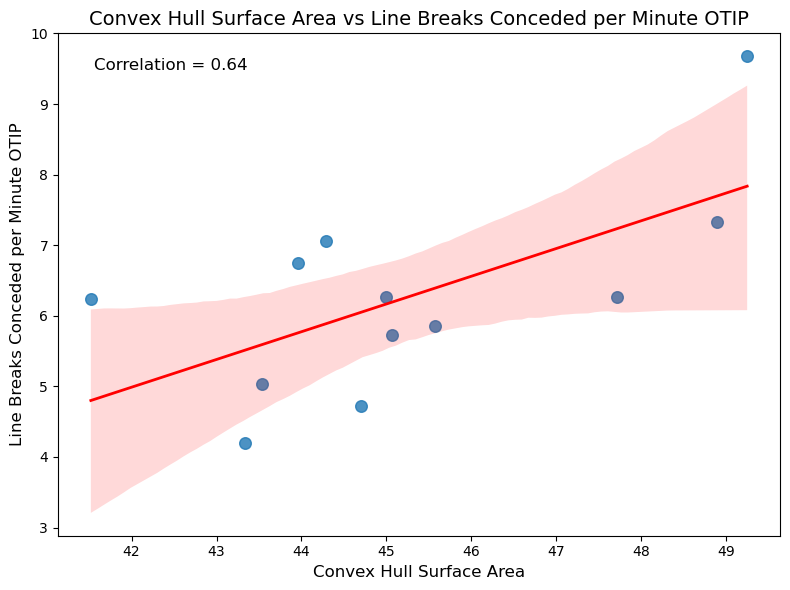

In [81]:
# TEST THE BRELATIONSHIP BETWEEN POSITIONING METRIC AND LPB CONCEDED

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Example: your dataframe is named df
# Compute correlation
corr = team_conceded_norm['convex_hull_surface_area'].corr(team_conceded_norm['line_breaks_conceded_per_minute'])

# Create figure
plt.figure(figsize=(8, 6))
sns.regplot(
    data=team_conceded_norm,
    x='convex_hull_surface_area',
    y='line_breaks_conceded_per_minute',
    scatter_kws={'s': 70, 'alpha': 0.8},
    line_kws={'color': 'red', 'lw': 2}
)

# Add title and labels
plt.title('Convex Hull Surface Area vs Line Breaks Conceded per Minute OTIP', fontsize=14)
plt.xlabel('Convex Hull Surface Area', fontsize=12)
plt.ylabel('Line Breaks Conceded per Minute OTIP', fontsize=12)

# Add correlation text on plot
plt.text(
    0.05, 0.95,
    f'Correlation = {corr:.2f}',
    transform=plt.gca().transAxes,
    fontsize=12,
    verticalalignment='top',
    bbox=dict(facecolor='white', alpha=0.6, edgecolor='none')
)

plt.tight_layout()
plt.show()

In [82]:
### Merge phases and dynamic events for Streamlit App
def parse_time_to_seconds(t):
    if pd.isna(t):
        return np.nan
    try:
        parts = str(t).split(':')
        if len(parts) == 3:
            h_or_m, m_or_s, s = parts
            if int(h_or_m) < 10:
                minutes, seconds, tenths = map(float, parts)
                return minutes * 60 + seconds + tenths / 10
            else:
                hours, minutes, seconds = map(float, parts)
                return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:
            minutes, seconds = map(float, parts)
            return minutes * 60 + seconds
        else:
            return float(parts[0])
    except Exception:
        return np.nan

In [83]:
def merge_phases_and_events(tracking_df, phases_df, events_df):
    merged = tracking_df.copy()

    merged['event_subtype'] = np.nan
    merged['team_in_possession_phase_type'] = np.nan

    # Convert phase times
    phases_df = phases_df.copy()
    phases_df['start_time_seconds'] = (
        phases_df['minute_start'] * 60 + phases_df['second_start']
    )
    phases_df['end_time_seconds'] = phases_df['time_end'].apply(parse_time_to_seconds)
    phases_df['end_time_seconds'] = phases_df['end_time_seconds'].fillna(
        phases_df['start_time_seconds'] + phases_df['duration']
    )

    # Apply phases by half
    for period in [1, 2]:
        half_df = merged[merged['period'] == period]
        phases_half = phases_df[phases_df['period'] == period].sort_values('start_time_seconds')

        for _, row in phases_half.iterrows():
            start, end, phase_value = row['start_time_seconds'], row['end_time_seconds'], row['team_in_possession_phase_type']
            mask = (half_df['timestamp'] >= start) & (half_df['timestamp'] <= end)
            merged.loc[mask & (merged['period'] == period), 'team_in_possession_phase_type'] = phase_value

    # Apply events
    events_df = events_df.copy()
    events_df['time_start'] = events_df['time_start'].apply(parse_time_to_seconds)
    events_df['time_end'] = events_df['time_end'].apply(parse_time_to_seconds)
    events_df = events_df.sort_values('time_start')

    for _, event in events_df.iterrows():
        player = event['player_id']
        start, end, subtype, period = event['time_start'], event['time_end'], event['event_subtype'], event['period']
        mask = (
            (merged['player_id'] == player)
            & (merged['period'] == period)
            & (merged['timestamp'] >= start)
            & (merged['timestamp'] <= end)
        )
        merged.loc[mask, 'event_subtype'] = subtype

    return merged

In [86]:
merged_results = []

for match_id, match_df in tqdm(df.groupby('match_id'), desc="Merging phases & events"):
    # Load that match’s metadata
    match_json, dynamic_df, phases_df = load_match_metadata(match_id)
    
    # Merge the metadata into the tracking data
    merged_df = merge_phases_and_events(match_df, phases_df, dynamic_df)
    
    merged_results.append(merged_df)

# Combine back into one big DataFrame
df_merged = pd.concat(merged_results, ignore_index=True)

Merging phases & events:   0%|          | 0/10 [00:00<?, ?it/s]C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\1066413258.py:25: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'create' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged.loc[mask & (merged['period'] == period), 'team_in_possession_phase_type'] = phase_value
C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\1066413258.py:42: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'pressing' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  merged.loc[mask, 'event_subtype'] = subtype
Merging phases & events:  10%|█         | 1/10 [02:32<22:54, 152.77s/it]C:\Users\stuart.macfarlane\AppData\Local\Temp\ipykernel_26780\3858413467.py:23: DtypeWarning: Columns (276) 

In [91]:
df_merged['is_defending'] = (df_merged['team_id'] != df_merged['ball_owning_team']).astype(int)

In [98]:
### <----------- THIS IS THE FINAL SAVE TO TRANSFER TO STREAMLIT APP -------------->

## Convert to parquet to speed up Stremalit processing
df_merged["attacking_direction"] = df_merged["attacking_direction"].astype(str)

# Also convert anything else that's an enum/custom object
df_merged["team_in_possession_phase_type"] = df_merged["team_in_possession_phase_type"].astype(str)
# Save to parquet
df_merged.to_parquet(
    "skillcorner_x_pysport_events_with_phases.parquet",
    index=False,
    compression="snappy"
)